Custom MobileNetV2 Model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

Set data directory, wanted batch size and the number of epochs for the training process

In [3]:
dataDir = "Dataset"
batchSize = 16
numEpochs = 5

Try to utilizes CUDA-cores for training, otherwise the CPU will be used. The path for the model is also determined

In [ ]:
modelPath = "mobilenetv2_screw_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\theis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


The imagetransformation is defined and the images will be resized to 224x224, as ResNet18 was trained on that size.

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
train_dataset = datasets.ImageFolder(os.path.join(dataDir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(dataDir, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['Machine', 'Philips', 'Plaster', 'Torx']


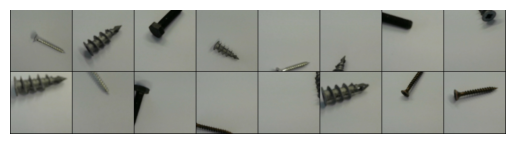

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images from your custom dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images as a grid
imshow(torchvision.utils.make_grid(images))

The model is loaded/downloaded

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

c:\Users\theis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\theis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


With the model loaded, the training of the ResNet18 model using the images taken can be initialized

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 1
best_loss = float('inf')
counter = 0

print(f"Training MobileNetV2 model")
for epoch in range(numEpochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{numEpochs}, Loss: {avg_loss:.4f}")

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0  # reset if improvement
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Training ResNet18 model
Epoch 1/5, Loss: 0.2336
Epoch 2/5, Loss: 0.1845
Epoch 3/5, Loss: 0.1319
Epoch 4/5, Loss: 0.1210
Epoch 5/5, Loss: 0.0994


When the model i trained, the validation images will be used to find the accuracy of the ResNet model

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 97.53%


To visualize the class prediction a confusion matrix is made

<Figure size 1000x800 with 0 Axes>

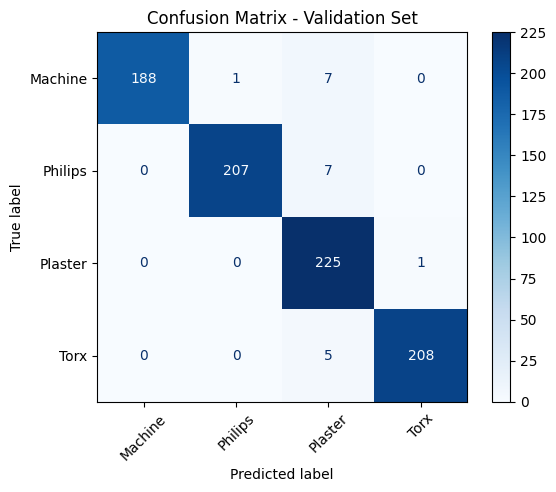

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - Validation Set")
plt.show()

Save the model

In [12]:
torch.save(model.state_dict(), modelPath)
print(f"Model saved to {modelPath}")

Model saved to resnet18_screw_classifier.pth
